# Implicit Trajectory combined with RRT #
- Work space: 3D with obstacles
- Obstacle type: static and known
- Agent Model: Dubins airplane (Owen2015)
- Integration Algorithm: 4th Order Runge Kutta
- Implicit Curve: Time-invariant Circle
- Distance Metric: admissionable heuristic, based on time-optimal dubins-airplane paths (altitude difference is integrated in a linear fashion)

In [1]:
%matplotlib inline

# load the code
%run 'MAIN_CODE.ipynb'

# Stage 1: Find Path to Curve

In [2]:
import numpy as np
import random

random.seed( 500 ) #arbitrary
qstart = np.array([10.,10.,-10.,np.pi])
Obstacles = CreateSphericalObstacles(N=100,r=2)
while isBlocked(qstart, Obstacles):
    Obstacles = CreateSphericalObstacles(N=100,r=2)

In [3]:
#%matplotlib notebook
import pdb
import random as rnd

# Experiment parameters
MaxNodes = 500
MAXiter = MaxNodes*3
lambdaNsteps=40
Es=0.8
lamdb=1.0

# Execute and return Tree
random.seed( 500 ) #arbitrary
T = VFRRT(qstart,VF,lambdaNsteps,Es,lamdb,MaxNodes,MAXiter,Obstacles,bounds=bounds)
_,S1path,_ = T.get_solution()

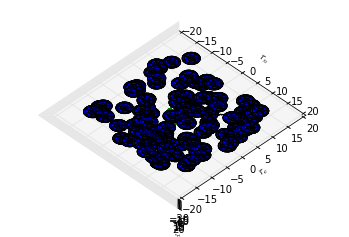

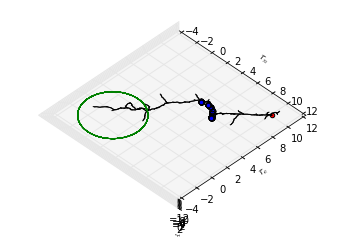

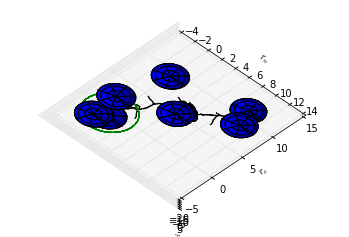

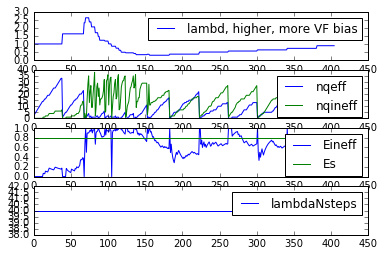

In [4]:
T.plot(obs=Obstacles)

T.plot(DrawTrajectory=True,DrawCollisionNodes=True)

T.plot(obs=Obstacles,OnlyClosestObs=True,DrawCollisionNodes=True)

DrawStats(T)

plt.show()

# Stage 2: Create a Trajectory that closes the Loop #
Pseudocode:
1. Naive solution
2. Remove blocked nodes
3. Connect subsets of the path

## Naive Solution

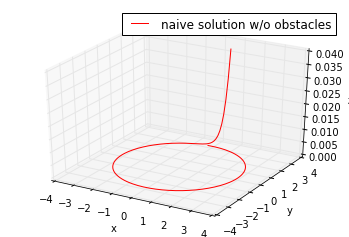

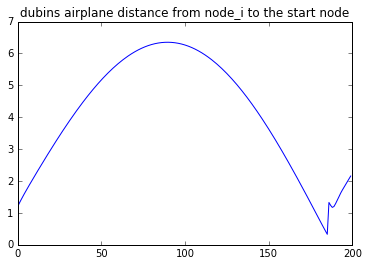

In [5]:
#%matplotlib inline
import numpy as np

MAXnodes = 200

# start on curve
#qstart = np.array([xc+r,yc,zc,0.])
#qstart[-1] = VFangle(qstart)
qstart = S1path[-1]

qList = [qstart]
distList = []
q = qstart
for i in range(0,MAXnodes):
    #import pdb; pdb.set_trace()
    # steer in the direction of the VF
    offset = VF(q)*inputBounds["Vmax"]*TimeStep
    newangle = VFangle(q[0:3]+offset)
    qVF = np.append(q[0:3]+offset,newangle)
    qnew = steer(q,qVF)
    q = qnew
    qList.append(qnew)
    
    distList.append(dubinsDist(qnew,qstart)) 
    if distList[-1]<=DistStep*2:
        print('finished after %d iterations' % i)
        break

def plotQlist(qList,text=''):
    # split the List of arrays into plottable data
    x,y,z,t = zip(*qList)

    #ax.plot(curve[2000:,0], curve[2000:,1], curve[2000:,2], label='integral curve', color='green')# the VF traj
    if text=='':
        plt.plot(x, y, z, color='red')
    else:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot(x, y, z, label=text,color='red')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.legend()


plotQlist(qList,'naive solution w/o obstacles')

# Plot dubins airplane distance from the newest node to the start node
fig = plt.figure()
ax = fig.gca()
ax.plot(distList)
plt.title('dubins airplane distance from node_i to the start node')

plt.show()

## Find blocked nodes

In [6]:
# Spherical Obstacle Definition
ob = dict()
ob["pos"] = np.array([xc-r*1/np.sqrt(2),yc-r*1/np.sqrt(2),zc])
ob["r"] = 0.5

Obs = list()
Obs.append(ob)

# Split the qList in subsets whenever an obstacle blocks a node
oldResult = isBlocked(qList[0],Obs)
toConnect = []
for i in range(1,len(qList)):
    newResult = isBlocked(qList[i],Obs)
    if newResult and not oldResult:
        ilast = i-1
    if not newResult and oldResult:
        ifirst = i
        toConnect.append((ilast,ifirst))
    oldResult = newResult

print(toConnect)

[(75, 86)]


## Use RRT to connect the subsets

Result: True


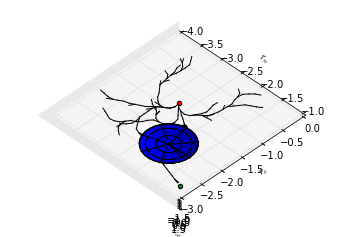

In [7]:
#%matplotlib notebook
for pair in toConnect:
    l,f=pair
    
    # VFRRT parameters
    MaxNodes = 450
    MAXiter = MaxNodes*3
    #lambdaNsteps=100
    #Es=0.9
    #lamdb=1.0
    off=5
    qs = qList[l-off]
    qf = qList[f+off]
    
    # sample bounds
    bounds = dict()
    edge = 2.0
    bounds["xmin"] = qs[0]-edge
    bounds["xmax"] = qs[0]+edge
    bounds["ymin"] = qs[1]-edge
    bounds["ymax"] = qs[1]+edge
    bounds["zmin"] = qs[2]-edge
    bounds["zmax"] = qs[2]+edge
    
    # Execute and return Tree
    #T1,T2,path = VFRRT(qs,VF,lambdaNsteps,Es,lamdb,MaxNodes,MAXiter,Obs,bounds=bounds,connect=True,qfinal=qf)
    random.seed( 500 ) #arbitrary
    Trrt = RRT(qs,qf,MaxNodes,MAXiter,Obs,bounds,goalBias=0.25)
    _,S2path,_ = Trrt.get_solution()
#T1.plot(obs=Obs,DrawCollisionNodes=True,DrawTrajectory=False)
#T2.plot(obs=Obs,DrawCollisionNodes=True,DrawTrajectory=False)
#print("Min Distance from T1 to T2 %.3f" % np.min(T1.dists))
#print("Min Distance from T1 to T2 %.3f" % np.min(T2.dists))
#DrawStats(T1)
#DrawStats(T2)

#RRT
Trrt.connect = True
Trrt.qfinal = qf
print('Result: %s' % Trrt.successful)
Trrt.plot(DrawTrajectory=False,DrawCollisionNodes=True,obs=Obs,OnlyClosestObs=True)

#T.plot(obs=Obs,DrawCollisionNodesDrawStats(T)=True,DrawTrajectory=False)
#DrawStats(T)

#plt.figure()
#plt.plot(dists)
#plt.title('dubins distances min=%.2f' % np.min(dists))

plt.show()

In [8]:
# this was to see the distances from one tree to the other
#plt.figure()
#plt.plot(np.sort(T1.dists))
#plt.title('T1 dubins distances min=%.2f' % np.min(T1.dists))

#plt.figure()
#plt.plot(np.sort(T2.dists))
#plt.title('T2 dubins distances min=%.2f' % np.min(T2.dists))

#plt.show()

# Putting it all together for a nice Plot

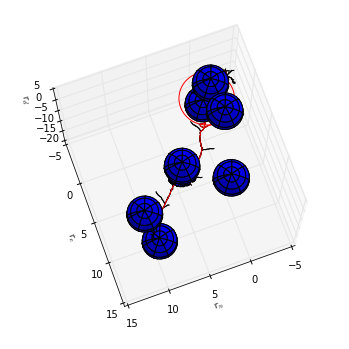

In [9]:
%matplotlib inline
## Stage 1 path + Obstacles
# tree
T.plot(DrawTrajectory=False,obs=Obstacles,OnlyClosestObs=True,DrawCollisionNodes=True)
# solution
plotQlist(S1path)

## Stage two Naive+SubPath + Obstacle
plotQlist(qList[0:l-off]) # naive part 1
plotQlist(qList[f+off:-1]) # naive part 2
# tree
Trrt.plot(DrawTrajectory=False,DrawCollisionNodes=True,obs=Obs,OnlyClosestObs=True,samePlot=True)
# solution
plotQlist(S2path)

fig = plt.gcf()
ax1 = plt.gca()

ax1.view_init(elev=75., azim=70)
fig.set_size_inches(6, 6)

plt.show()


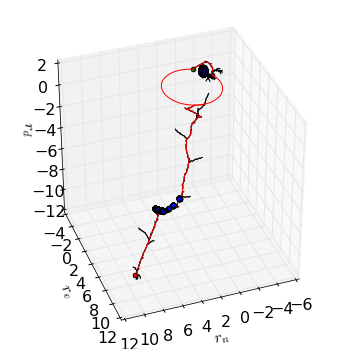

In [10]:
%matplotlib inline
## Stage 1 path + Obstacles
# tree
T.plot(DrawTrajectory=False,DrawCollisionNodes=True)
# solution
plotQlist(S1path)

## Stage two Naive+SubPath + Obstacle
plotQlist(qList[0:l-off]) # naive part 1
plotQlist(qList[f+off:-1]) # naive part 2
# tree
Trrt.plot(DrawTrajectory=False,DrawCollisionNodes=False,obs=Obs,OnlyClosestObs=True,samePlot=True)
# solution
plotQlist(S2path)

fig = plt.gcf()
ax1 = plt.gca()

ax1.view_init(elev=35., azim=70)
fig.set_size_inches(6, 6)
mpl.rcParams.update({'font.size': 16})
plt.show()

# Intersection Cylinder and plane

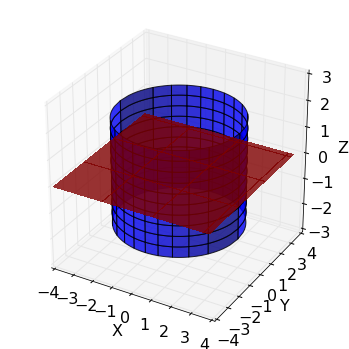

In [11]:
#%matplotlib wx 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = fig.add_subplot(111, projection='3d')

# Cylinder part below
rc = 3.
x=np.linspace(-rc, rc, 100)
z=np.linspace(-2, 0, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(rc**2-Xc**2)
# Draw parameters
rstride = 20
cstride = 10
ax.plot_surface(Xc, Yc, Zc, alpha=0.8, rstride=rstride, cstride=cstride)
ax.plot_surface(Xc, -Yc, Zc, alpha=0.8, rstride=rstride, cstride=cstride)


# Plane
X = np.arange(-4, 4, 0.25)
xlen = len(X)
X, Y = np.meshgrid(X, X)
Z = X*0.

surf = ax.plot_surface(X, Y, Z, rstride=10, cstride=10,
                       linewidth=0, antialiased=False,alpha=0.8,
                       color='red')

# part above
x=np.linspace(-rc, rc, 100)
z=np.linspace(0, 2, 100)
Xc, Zc=np.meshgrid(x, z)
Yc = np.sqrt(rc**2-Xc**2)
# Draw parameters
rstride = 20
cstride = 10
ax.plot_surface(Xc, Yc, Zc, alpha=0.8, rstride=rstride, cstride=cstride)
ax.plot_surface(Xc, -Yc, Zc, alpha=0.8, rstride=rstride, cstride=cstride)



# Circle

# aspect ratio 
ax.set_aspect('equal')
MAX = 3
for direction in (-1, 1):
    for point in np.diag(direction * MAX * np.array([1,1,1])):
        ax.plot([point[0]], [point[1]], [point[2]], 'w')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()